# A-Star Path Planning

> In this notebook, the A* algorithm is employed to solve the path planning problem.

## (OPTIONAL) Read in Grid with OpenCV

> To demonstrate my knowledge of CV libraries, I wrote this code snippet that interprets a 5x5 grid from an image, such as a screenshot from the PDF. The output is a structured grid in numpy array format.  </br>

> Please feel free to disregard this section if it doesn’t align with the focus of the assignment.

> For simplicity and to avoid the use of OCR models, we assume the grid's dimensions and the locations of the start and end points are known

### Preprocessing

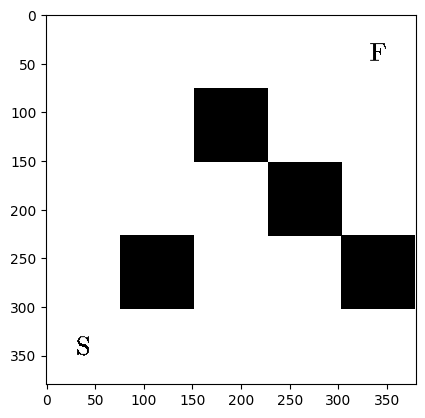

In [62]:
import numpy as np
import cv2


file_path = './grid.jpg'


img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Invert the image to identify the countours
inv_img = cv2.bitwise_not(img)

contours, _ = cv2.findContours(inv_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# The largest contour is the border, find its bounding box
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the image to exclude the border, then invert it back
cropped_img = cv2.bitwise_not(inv_img[y:y+h, x:x+w])

# Threshold the image to get a binary image
_, thresh = cv2.threshold(cropped_img, 127, 1, cv2.THRESH_BINARY)

# Check if the preprocessing is correct
import matplotlib.pyplot as plt
plt.imshow(thresh, cmap='gray')

In [63]:
# Cell dimensions
cell_height = thresh.shape[0] // 5
cell_width = thresh.shape[1] // 5

# Initialize the grid array
grid = np.ones((5, 5))
# set cell values
for i in range(5):
    for j in range(5):
        cell = thresh[i*cell_height : (i+1)*cell_height, 
                      j*cell_width : (j+1)*cell_width]
        
        if np.mean(cell) >= 0.9:
            grid[i, j] = 0  # white cell

grid[4, 0] = 2  # 'S' at bottom left
grid[0, 4] = 3  # 'F' at top right
print(grid)


[[0. 0. 0. 0. 3.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [2. 0. 0. 0. 0.]]


## 2. Basic Path Planning Implementation

#### Task 1 & 2: Create a 5x5 grid with the obstacles, mark start and end points

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Visiualize the grid with simple numpy array
grid = np.zeros((5, 5))

# Add obstacles to the grid
obstacles = [(1, 2), (2, 3), (3, 1), (3, 4)]
for (x, y) in obstacles:
    grid[x, y] = 1

start_point = (4, 0)  # start 
finish_point = (0, 4) # finish 

# use 2 for start and 3 for finish
grid[start_point] = 2  
grid[finish_point] = 3 

print("\nGrid with Start (S) and Finish (F) points:")
print(grid)



Grid with Start (S) and Finish (F) points:
[[0. 0. 0. 0. 3.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [2. 0. 0. 0. 0.]]


#### Task 3: Algorithm Implementation

In [65]:
from queue import PriorityQueue

# Helper function to return the list of valid neighbors
def get_neighbors(node):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0),]  # assume we can move in 4 directions only, add more if you like (diagnoal moves etc.)
    # directions.extend([ (-1, 1), (1, 1), (1, -1), (-1, -1),])
    result = []
    for direction in directions:
        neighbor = (node[0] + direction[0], node[1] + direction[1])
        if 0 <= neighbor[0] < 5 and 0 <= neighbor[1] < 5:  # Check if within bounds
            if grid[neighbor] != 1:  # if it's not an obstacle
                result.append(neighbor)
    return result

# Heuristic function for A* is simply the Manhattan distance
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# A* algorithm
def astar(start, goal):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()[1]
        
        if current == goal:
            break
        
        for next in get_neighbors(current):
            new_cost = cost_so_far[current] + 1
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put((priority, next))
                came_from[next] = current
    
    # Reconstruct path
    path = []
    if goal in came_from:
        current = goal
        while current != start:
            path.append(current)
            current = came_from[current]
        path.append(start)  
        path.reverse() 

    return path, cost_so_far[goal] if goal in cost_so_far else float('inf')

# Find the shortest path from start to finish
path, cost = astar(start_point, finish_point)


print("The shortest path from Start to Finish:")
print("Path:", path)
print("Cost:", cost)


path_grid = np.array(grid)
for step in path:
    path_grid[step] = 4  # Representing the path with a 4

print("\nVisualization with numpy:")
print(path_grid)


The shortest path from Start to Finish:
Path: [(4, 0), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Cost: 8

Visualization with numpy:
[[4. 4. 4. 4. 4.]
 [4. 0. 1. 0. 0.]
 [4. 0. 0. 1. 0.]
 [4. 1. 0. 0. 1.]
 [4. 0. 0. 0. 0.]]


#### Task 4: Visualization

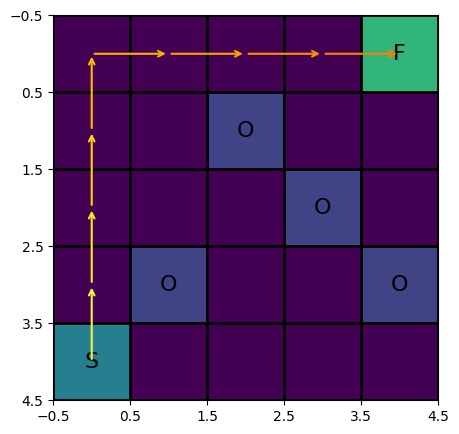

In [66]:
# Visualizations
    
def visualize_path_on_grid(start_point, finish_point, path, path_grid, obstacles=[(1, 2), (2, 3), (3, 1), (3, 4)], waypoints=[(2, 2), (1, 4)]):
    
    # for step in path:
    #     path_grid[step] = 4

    fig, ax = plt.subplots(figsize=(5, 5))

    cmap = plt.cm.viridis
    ax.imshow(path_grid, cmap=cmap, vmin=0.1, vmax=4.5)

    # gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='black', linewidth=2)
    ax.set_xticks(np.arange(-.5, 5, 1))
    ax.set_yticks(np.arange(-.5, 5, 1))

    # Draw the start and finish points
    ax.text(start_point[1], start_point[0], 'S', va='center', ha='center', color='black', fontsize=16)
    ax.text(finish_point[1], finish_point[0], 'F', va='center', ha='center', color='black', fontsize=16)
    for obstacle in obstacles: 
        ax.text(obstacle[1], obstacle[0], 'O', va='center', ha='center', color='black', fontsize=16)
    for waypoint in waypoints: 
        ax.text(waypoint[1], waypoint[0], 'W', va='center', ha='center', color='black', fontsize=16)

    # Draw the arrows representing the path
    temp_path = path.copy()
    num_steps = len(temp_path)
    colors = plt.cm.Wistia(np.linspace(0, 1, num_steps))
    count = 0
    while len(temp_path) > 1:
        start = temp_path.pop(0)
        count += 1
        end = temp_path[0]
        ax.annotate("",
                xy=(end[1],end[0]), xycoords='data',
                xytext=(start[1],start[0]), textcoords='data',
                arrowprops=dict(arrowstyle="->", color=colors[count], lw=1.5))

    
    # ax.axis('off')
    
    plt.show()
path_grid = np.array(grid)
visualize_path_on_grid(start_point, finish_point, path, path_grid, obstacles, waypoints=[])



## 3. Integration of Waypoints


> The goal of this task is to find a path that includes the given waypoints.<br>
> Thanks to the property of optimal substructure, we can easily break this problem into subproblems of finding path from start to way-point 1, from way-point 1 to way-point 2 ... and finally to the finish point.<br>
> This is done through calling astar multiple times.

Complete path including waypoints:
[(4, 0), (3, 0), (2, 0), (2, 1), (2, 2), (2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (0, 4)]
Total cost: 12


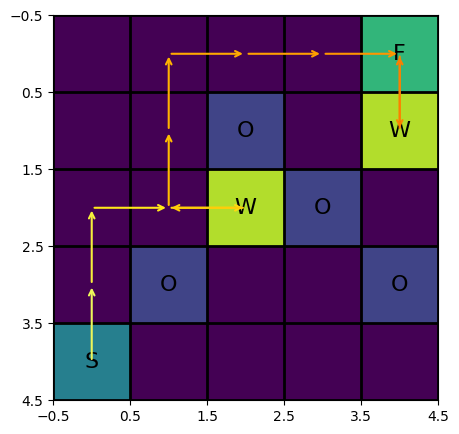

In [67]:
waypoints = [(2, 2), (1, 4)]
def plan_path_with_waypoints(start, waypoints, finish):
    complete_path = []
    total_cost = 0
    
    # to store each waypoint as temporary start
    temp_start = start
    
    # Iterate through the waypoints and calculate path segments
    for waypoint in waypoints:
        # Find the path to the next waypoint
        path_to_waypoint, cost_to_waypoint = astar(temp_start, waypoint)
        total_cost += cost_to_waypoint
        
        # Exclude the start point of the segment if it's not the initial start
        if complete_path:
            path_to_waypoint = path_to_waypoint[1:]
        
        # Add the segment to the complete path
        complete_path.extend(path_to_waypoint)
        
        # Update the temporary start
        temp_start = waypoint
    
    # Find the path from the last waypoint to the finish point
    path_to_finish, cost_to_finish = astar(temp_start, finish)
    total_cost += cost_to_finish
    
    if complete_path:
        path_to_finish = path_to_finish[1:]
    
  
    complete_path.extend(path_to_finish)
    
    return complete_path, total_cost

complete_path, total_cost = plan_path_with_waypoints(start_point, waypoints, finish_point)

print("Complete path including waypoints:")
print(complete_path)
print("Total cost:", total_cost)
path_grid = np.array(grid)
for points in waypoints:
    path_grid[points]=4
visualize_path_on_grid(start_point, finish_point, complete_path, path_grid)

> However, as shown above, our algorithm allows solution that passes through the finish point before it has visited all the waypoints.<br>
> This is a bit counter-intuitive. We can avoid this by temporarily setting the finish point as an obstacle before all the waypoints have been visited.


### (Optional) Avoid passing through the finish point

Complete path including waypoints:
[(4, 0), (3, 0), (2, 0), (2, 1), (2, 2), (2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (0, 4)]
Total cost: 12


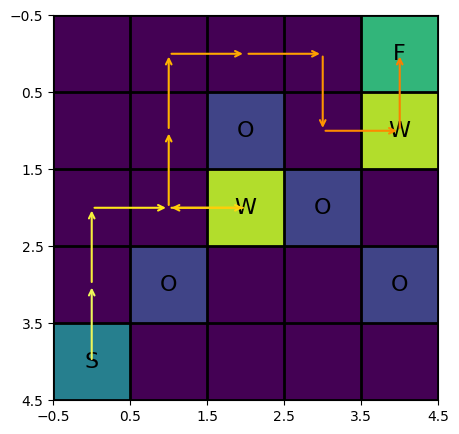

In [68]:
waypoints = [(2, 2), (1, 4)]
# Adjust the astar function to accept grid as an argument
def astar_modified(start, goal, grid):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()[1]
        
        if current == goal:
            break
        
        for next in get_neighbors_modified(current, grid):
            new_cost = cost_so_far[current] + 1
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                frontier.put((priority, next))
                came_from[next] = current
    
    # Reconstruct path
    path = []
    if goal in came_from:
        current = goal
        while current != start:
            path.append(current)
            current = came_from[current]
        path.append(start)  
        path.reverse()  

    return path, cost_so_far[goal] if goal in cost_so_far else float('inf')

# Helper function to return the list of valid neighbors with modified grid
def get_neighbors_modified(node, grid):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), ]  # 4 possible directions to move: right, down, left, up
    # directions.extend([ (-1, 1), (1, 1), (1, -1), (-1, -1),])
    result = []
    for direction in directions:
        neighbor = (node[0] + direction[0], node[1] + direction[1])
        if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:  
            if grid[neighbor] != 1:  
                result.append(neighbor)
    return result
# Function to plan a path including waypoints
def plan_path_with_waypoints_modified(start, waypoints, finish, grid):
    complete_path = []
    total_cost = 0
    
    # will be updated to each waypoint in sequence
    temp_start = start
    temp_grid = np.copy(grid)
    temp_grid[finish_point] = 1
    
    for waypoint in waypoints:
        # Find the path to the next waypoint
        path_to_waypoint, cost_to_waypoint = astar_modified(temp_start, waypoint, temp_grid)
        total_cost += cost_to_waypoint
        
        # Exclude the start point of the segment if it's not the initial start
        if complete_path:
            path_to_waypoint = path_to_waypoint[1:]
        
        # Add the segment to the complete path
        complete_path.extend(path_to_waypoint)
        
        # Update the temporary start to the current waypoint
        temp_start = waypoint
    
    # Find the path from the last waypoint to the finish point
    path_to_finish, cost_to_finish = astar(temp_start, finish)
    total_cost += cost_to_finish
    

    if complete_path:
        path_to_finish = path_to_finish[1:]
    
    complete_path.extend(path_to_finish)
    
    return complete_path, total_cost

path_grid = np.array(grid)
complete_path, total_cost = plan_path_with_waypoints_modified(start_point, waypoints, finish_point, path_grid)

print("Complete path including waypoints:")
print(complete_path)
print("Total cost:", total_cost)
path_grid = np.array(grid)
for points in waypoints:
    path_grid[points]=4
visualize_path_on_grid(start_point, finish_point, complete_path, path_grid)

> That looks better. We could further add constraints to not allow for going back to a visited block by similarly setting visited blockes as obstacles, you get the idea. 

## 4. Varying Terrain

> We basically leverage the elevation information by updating the cost not by 1, but by the elevation gain. 

Path considering terrain elevation:
[(4, 0), (3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Total elevation gain: 2


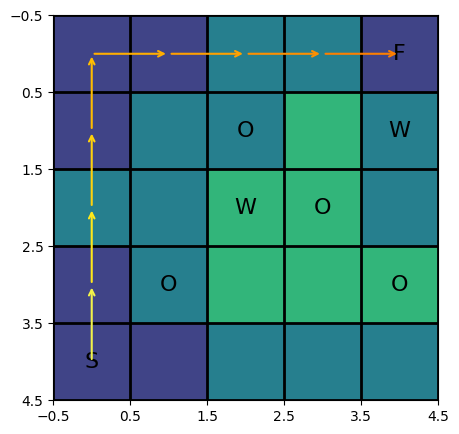

In [76]:
#the elevation data
elevation_grid = np.array([
    [1, 1, 2, 2, 1],  
    [1, 2, 2, 3, 2],
    [2, 2, 3, 3, 2],
    [1, 2, 3, 3, 3],
    [1, 1, 2, 2, 2]
])

waypoints = [(2, 2), (1, 4)]
def astar_terrain(start, goal, grid, elevation):
    frontier = PriorityQueue()
    frontier.put((0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()[1]
        
        if current == goal:
            break
        
        for next in get_neighbors_modified(current, grid):
            new_cost = (cost_so_far[current] + 1 # Cost based on movement
                        + (elevation[next] - elevation[current] 
                           if elevation[next] > elevation[current] else 0))  # Cost based on elevation gain 
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next) 
                frontier.put((priority, next))
                came_from[next] = current
    

    path = []
    if goal in came_from:
        current = goal
        while current != start:
            path.append(current)
            current = came_from[current]
        path.append(start)  
        path.reverse()  

    return path, cost_so_far[goal] if goal in cost_so_far else float('inf')


path_grid = np.array(grid)

path_terrain, cost_terrain = astar_terrain(start_point, finish_point, grid, elevation_grid)

print("Path considering terrain elevation:")
print(path_terrain)
print("Total elevation gain:", cost_terrain - len(path_terrain) + 1)
visualize_path_on_grid(start_point, finish_point, path_terrain, elevation_grid)

> But this is not really fun since we don't observe any change from the original implementation.</br>
> Let's addtionally try some other elevation map to check if the implementation is correct. 

### (Optional) New Elevation Map

Path considering terrain elevation:
[(4, 0), (3, 0), (2, 0), (2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4)]
Total elevation gain: 1


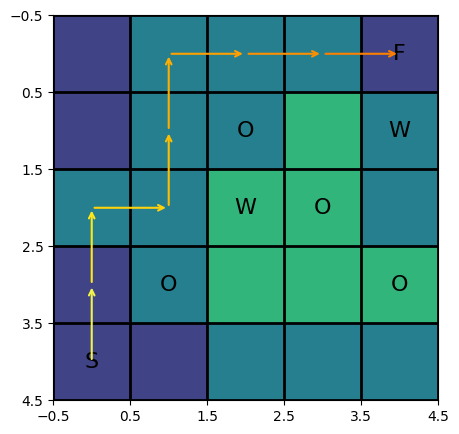

In [78]:
#my elevation data
my_elevation_grid = np.array([
    [1, 2, 2, 2, 1],  
    [1, 2, 2, 3, 2],
    [2, 2, 3, 3, 2],
    [1, 2, 3, 3, 3],
    [1, 1, 2, 2, 2]
])
path_terrain, cost_terrain = astar_terrain(start_point, finish_point, grid, my_elevation_grid)

print("Path considering terrain elevation:")
print(path_terrain)
print("Total elevation gain:", cost_terrain - len(path_terrain) + 1)
visualize_path_on_grid(start_point, finish_point, path_terrain, my_elevation_grid)

> This works as intended, awesome!